# Load DeepFly3D Data

In [3]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D/', # change the path 
               'out_dir'        : '/data/LiftPose3D/fly_tether/cams_test3/',
               'train_subjects' : [1],
               'test_subjects'  : [6],
               'actions'        : ['all'],
               'cam_id'         : [0,1,2,4,5,6]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

train_3d = world_to_camera_dict(train_3d, rcams_train)
test_3d = world_to_camera_dict(test_3d, rcams_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [4]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import add_noise

lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":100},
          )#augmentation=[add_noise(noise_amplitude=.1)])

[main.py:252]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/cams_test3/stat_2d.pth.tar.
[main.py:271]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/cams_test3/stat_3d.pth.tar.
[main.py:298]:INFO:Starting training model.
[main.py:308]:DEBUG:
==================Options=================
[main.py:309]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/cams_test3',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 100,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/cams_test3',
    'out_dir': '/data/LiftPose3D/fly_tether/cams_test3',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:310]:DEBUG:==========================================

[lift.py:31]:INFO:Training on the device

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.45575|:  22%|██▏       | 2140/9871 [00:30<01:49, 70.83it/s]Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/home/user/anaconda3/envs/lf3d/lib/python3.7/multiprocessing/resource_sharer.p

KeyboardInterrupt: 

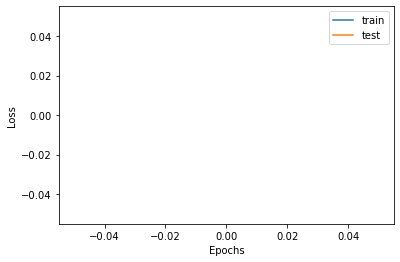

In [6]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [9]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:389]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/cams_test
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:55]:INFO:total params: 4.33M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/cams_test/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 1 | err: 0.19291848080942428)
[lift.py:105]:INFO:Saving results: /data/LiftPose3D/fly_tether/cams_test/test_results.pth.tar


# Visualize Predictions

In [10]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

[0. 0. 0. ... 0. 0. 0.]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[[660.  210. ]
 [660.  210. ]
 [660.  210. ]
 ...
 [615.  300. ]
 [615.  285. ]
 [622.5 285. ]]
[[  1.4425755   1.9016949 119.05612  ]
 [  1.4410856   1.901379  119.05243  ]
 [  1.4679621   1.8620949 119.06007  ]
 ...
 [  1.7505336   1.15367   118.159874 ]
 [  1.7278205   1.130952  118.25665  ]
 [  1.7049744   1.3241141 118.20113  ]]


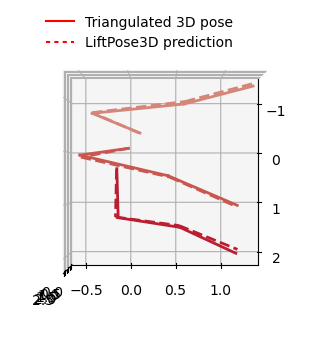

In [6]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0)

t = 0
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t])